In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

<div style="background-color: pink; padding: 10px">
# YOUR SURNAME: Benvenuto YOUR NAME: Giulia

# Understanding the Viola and Jones face detector

The goal of the lab is to encourage you do dive deeper into some core aspects of the VJ detector implementation and usage. The activity is devided into 2 somewhat independent parts. 



<div style="background-color: pink; padding: 10px">
Read all the parts (text and comments), and add your own comments whenever you find them appropriate (on the implementation choices, on the output you obtain...), but in particular where you are asked.


## Part1: Understanding building blocks

### 1.1: Integral images

Even if you will find an implementation of integral images already available on OpenCV, it will be instructive to do your own. Follow the instructions below.

<i>NOTICE (This was not clearly explained in the class but it is important to obtain an efficient implementation):</i>
<br>
    In each position of the image <tt>(y,x)</tt> except from the first row (y=0) and first column (x=0) the value of the integral image is computed by updating previously computed values see as follows:
<img src="sketch.png" width=600>


In [2]:
def integral_image(image):
    height, width = image.shape
    ii = np.zeros(image.shape)
    s = np.zeros(image.shape) # aux structure to precompute the sum of preceeding elements in the current row
    for y in range(height): 
        for x in range(width): 
            s[y][x] = s[y-1][x] + image[y][x] if y > 0 else image[y][x]
            ii[y][x] = s[y][x] + (ii[y][x-1] if y > 0 else 0)
    return ii

<b>Test</b> it on a real image and on a synthetic image.
To <b>evaluate</b> the quality of your result you may compare it with the OpenCV implementation <tt>cv2.integral</tt>

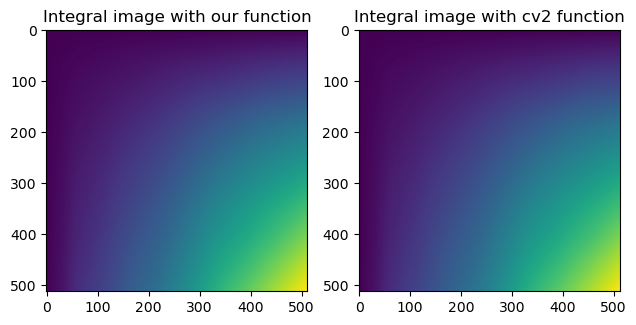

In [3]:
# load a real image
img = cv2.imread('Lena.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(integral_image(gray))
# plt.show()

# Integral image computed with our function:
plt.subplot(1, 2, 1)
plt.title("Integral image with our function")
plt.imshow(integral_image(gray))

# Integral image computed with the cv2 function:
plt.subplot(1, 2, 2)
plt.title("Integral image with cv2 function")
plt.imshow(cv2.integral(gray))

plt.tight_layout()
plt.show()

### Synthetic B/W image - First Try

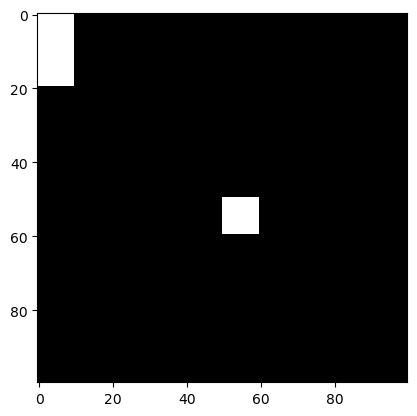

In [18]:
# BUILD a simple synthetic B/W image, for instance white rectangles over a black background (but you can make different ones)
# here's my example

I = np.zeros((100, 100))

I[0:20, 0:10] = 255
I[50:60, 50:60] = 255

# Before you run the integral image function ask yourself how you would expect the integral image to be in this case. 
# in the next cell you will check the actual output and be sure it makes sense to you

plt.imshow(I, cmap='gray')      
plt.show()

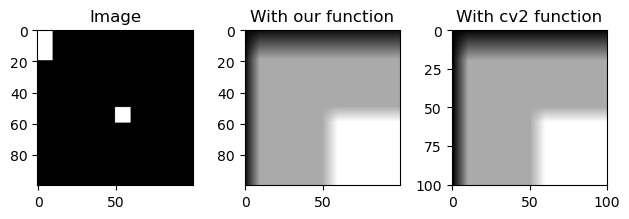

In [19]:
# Now you can visualize the integral image 
plt.subplot(1, 3, 1) 
plt.title("Image")
plt.imshow(I, cmap='gray')   

plt.subplot(1, 3, 2)
ii = integral_image(I)
plt.title("With our function")
plt.imshow(ii, cmap='gray')  

plt.subplot(1, 3, 3)
iicv2 = cv2.integral(I)
plt.title("With cv2 function")
plt.imshow(iicv2, cmap='gray') 

plt.tight_layout()
plt.show()

<div style="background-color: pink; padding: 10px">
On this first part there are no comments to add, but I suggest you do your best to check that  your implementation is correct and that at this point you really understand what an integral image is (you may try and change the synthetic image and see if the ii you produce makes sense to you)

### 1.2: The response of a rectangle feature of your choice

We now reason on the quality and quantity of rectangle features over an image. You may use the synthetic image for this part.

You first need to implement a function <tt>compute_rectangle</tt> that computes the sum of all the elements within a rectangle, exploiting the integral image (see formula on the slides)

Then 
- Select a Haar feature of your choice, choosing the pattern, the size and the aspect ratio. The only parameter changing would be its position wrt the image
- Apply it to the image and obtain a feature vector. Does the size and its values make sense to you?

In [40]:
# ii is an integral image, x starting column, y starting row, width and height of the rectangle
# search the formula in the slides
def compute_rectangle(ii, x, y, width, height):
    # slide 18 Object Detection
    # A+B+C+D --> 4+1-(2+3)
    # ii(p) + ii(s) - ii(q) - ii(r)
    return ii[y][x] + ii[y + height][x + width] - ii[y][x + width] - ii[y + height][x]


In [41]:
# this is a very naif implementation, you should just use it to get a feeling 
# of the procedure. Try and understand what it does
# if you've time you can do better than this
# here I chose a feature of a 20x20 square feature with a vertical WHITE,BLACK structure (fixed scale and aspect ratio)

def build_my_features(ii):
    height, width = ii.shape
    myw = 10
    myh = 20
    m = 5 # feature's min size
    features = []
    #for w in range(m, width-m):  # you should uncomment this if you want to try out different sizes and aspect ratio
        #for h in range(m, height-m):
    for w in range(myw, myw + 1): #these are dummy for just for consistency with the previous commented ones!
        for h in range(myh, myh + 1):
            i = 0
            while i + 2 * w < width:
                j = 0
                while j + h < height:
                    pos = compute_rectangle(ii, i, j, w, h)  
                    neg = compute_rectangle(ii, i+w, j, w, h)  
                    features.append(([pos], [neg]))              
                    j += 1
                i += 1
    return features

# features is a list of [[pos] [neg]] elements, one per each appropriate position in the image
# pos contains the sum of pixels values corresponding to the feature white area (of a given position in the image)
# neg contains the sum of pixels values corresponding to the feature black area 

<div style="background-color: pink; padding: 10px">  <b>OPTIONAL</b>: implement another function that computes 20x20 square features with a <b> horizontal </b> WHITE,BLACK structure

In [42]:
# in this function you will explore the list of features previosuly computed and compute the feature value 
#  (sum white elements - sum black elements)
def apply_features(features):
    X = np.zeros((len(features)))
    i = 0
    for positive_region, negative_region in features:
        X[i] = positive_region[0] - negative_region[0]
        i += 1
    return X 

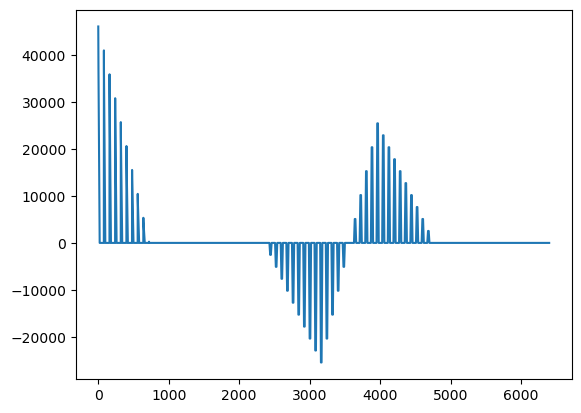

In [43]:
# run the functions on the synthetic image and
# for a better understanding you should change the synthetic image you're using
F = build_my_features(ii)
A = apply_features(F)
plt.plot(A)
plt.show()

In [46]:
print(A.shape)

(6400,)


<div style="background-color: pink; padding: 10px">
Describe the output you obtain, does it make sense? Do you understand what it means? (it may be useful to change the input synthetic feature to see how the feature vector changes.

**Observations:**  

The simple synthetic B/W image that we have generated has a black background and two small squares, one located in the left-top corner and the other one located almost in the center of the image. Here we computed a 20x20 square feature with a vertical WHITE,BLACK structure and then we applied it so we computed the sum of the pixels in the white region minus the sum of the pixels in the black region. 

The output makes sense to me: we obtain with this computation is an array of 6400 values because the feture we created is 20x20 and the sythetic image is 100X100 then we get 80x80 = 6400 values. 

The output starts with positive values decreasing because at the beginning of the procedure the feature is applied in the left-top corner where we also have the first little square. The shape of the square is 10 for the width and 20 for the height while the shape of the feature is 20 both for width and height; this means that the white side of the feature is perfectly overlapped to the white square and the black side of the feature is overlapping a black portion of the image then when we compute the difference sum of the pixels in the white region minus the sum of the pixels in the black region we get the the greatest possible value which is the first value of the output. 

Then the procedure continue by sliding the feature on the image. As the feature is translated to the right, the white side of it starts to overlap not only white pixels of the little square but also some black pixels of the background of the synthetic image so when the difference is computed the value will be smaller and smaller until we get to the situation where both the white and the black sides of the feature overlap a black portion of the image and in this situation we will get 0 values in the output. 

Furthermore when the feature overlaps the second little square at the beginning the white side will be over the black background while the black side will be over the white square this is why we get negative values in the output. As the feature slides onto the square the white side gets over the white square and the black side get over the black background again and in this situation we get again positive values in the output. 

Obviously if we change the synthetic image the output will change acconding to the position of the white squares. **Let's try with another B/W image**. 
<br>
<br>
<br>

We have just computed a feature vector of an image for a subset of the possible rectangle features (1 type, 1 aspect ratio, 1 size). Optionally, I suggested you could try with another one, in case you tried, the two vectors should be concatenated. 

In the real case we would concatenate all the possible variants of feature type, aspect ratio, size. Then we would build a feature matrix with one row per image. Similar image should have the same structure.
 


### Synthetic B/W image - Second Try

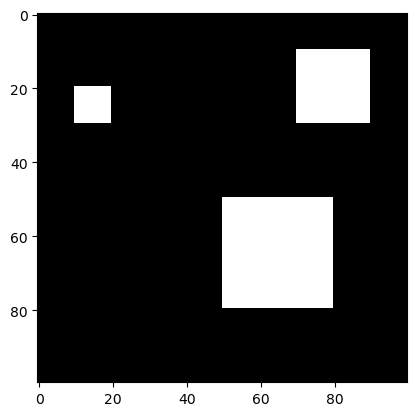

In [49]:
I = np.zeros((100, 100))

I[20:30, 10:20] = 255
I[50:80, 50:80] = 255
I[10:30, 70:90] = 255

plt.imshow(I, cmap='gray')      
plt.show()

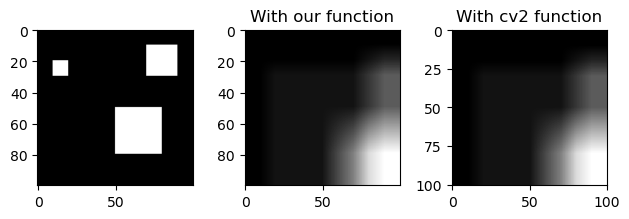

In [50]:
# Now you can visualize the integral image 
plt.subplot(1, 3, 1) 
plt.imshow(I, cmap='gray')   

plt.subplot(1, 3, 2)
ii = integral_image(I)
plt.title("With our function")
plt.imshow(ii, cmap='gray')  

plt.subplot(1, 3, 3)
iicv2 = cv2.integral(I)
plt.title("With cv2 function")
plt.imshow(iicv2, cmap='gray')  

plt.tight_layout()
plt.show()

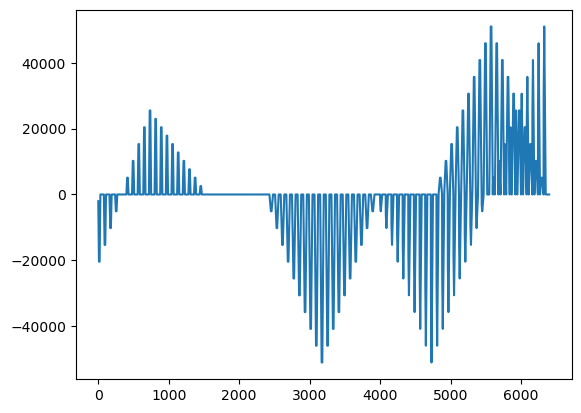

In [51]:
F = build_my_features(ii)
A = apply_features(F)
plt.plot(A)
plt.show()

## Part 2: Give it a try!

### 2.2 Face detection 

By now you should have a feeling of the type of feature vectors we may compute. Feature selection and training would be too long for a 2 hours lab, thus we play with the pre-implemented cascade classifier. You'll need to get familiar with the OpenCV function

<tt> Python: cv2.CascadeClassifier.detectMultiScale(image, scale_factor=1.1, min_neighbors=3, flags=0, min_size=(0, 0)) → detectedObjects</tt>

Parameters:	
- image – Matrix containing a graylevel image where objects are detected.
- objects – Vector of rectangles where each rectangle contains the detected object.
- scaleFactor – Parameter specifying how much the image size is reduced at each image scale.
- minNeighbors – Parameter specifying how many neighbors each candidate rectangle should have to retain it.
- flags – Parameter with the same meaning for an old cascade as in the function cvHaarDetectObjects. It is not used for a new cascade.
- minSize – Minimum possible object size. Objects smaller than that are ignored.
- maxSize – Maximum possible object size. Objects larger than that are ignored.

The detected objects will be returned as a list of rectangles

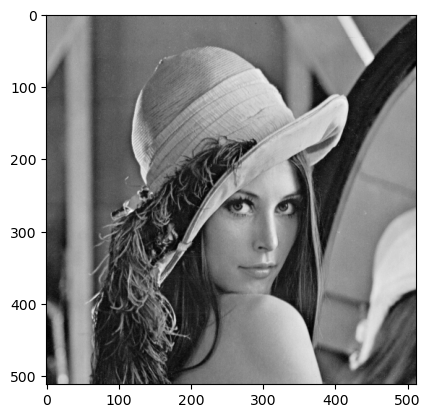

In [52]:
# We first load a classifier from an XML file
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# We now load an image and turn it to gray levels (don't forget this!)
img = cv2.imread('Lena.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

In [60]:
# notice: the following call is correct, but you must improve the results by adding optional parameters 
faces = face_cascade.detectMultiScale(gray)
print(faces) # let's have a look at the output

# With the parameters
faces = face_cascade.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 5, flags = 0)

[[218 202 173 173]]


In [61]:
def draw_rects(img, rects, color):
    for x1, y1, x2, y2 in rects:
        cv2.rectangle(img, (x1, y1), (x1+x2, y1+y2), color, 2)

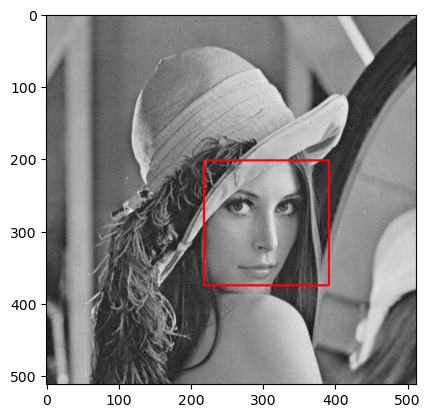

In [65]:
draw_rects(img, faces, (255, 0, 0))
plt.imshow(img)
plt.show()

### Your tests

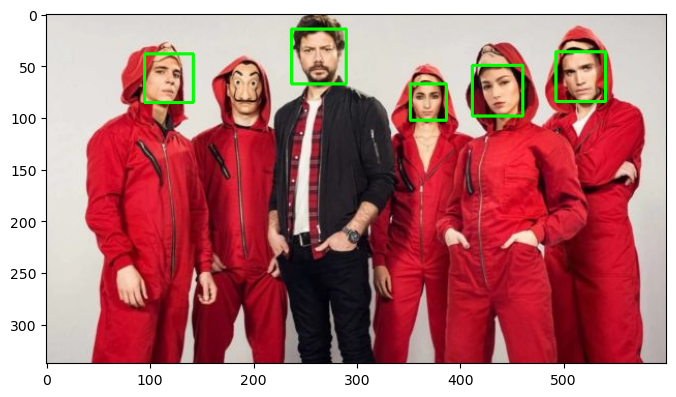

In [94]:
# detect and visualize faces in the following two images, complete all the required steps
cdp = cv2.imread('cdp2.jpg')
rgb = cv2.cvtColor(cdp, cv2.COLOR_BGR2RGB)

faces = face_cascade.detectMultiScale(rgb, scaleFactor = 1.1, minNeighbors = 5, flags = 0)
plt.figure(figsize = (8, 5))
draw_rects(rgb, faces, color = (0, 255, 0))
plt.imshow(rgb)
plt.show()

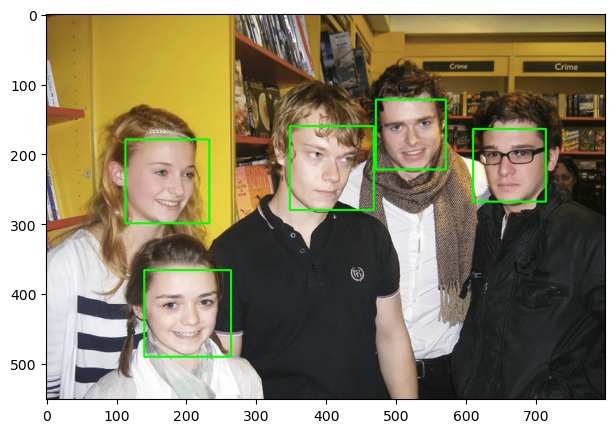

In [95]:
got = cv2.imread('got.png')
rgb = cv2.cvtColor(got, cv2.COLOR_BGR2RGB)

faces = face_cascade.detectMultiScale(rgb, scaleFactor = 1.1, minNeighbors = 5, flags = 0)
plt.figure(figsize = (8, 5))
draw_rects(rgb, faces, color = (0, 255, 0))
plt.imshow(rgb)
plt.show()

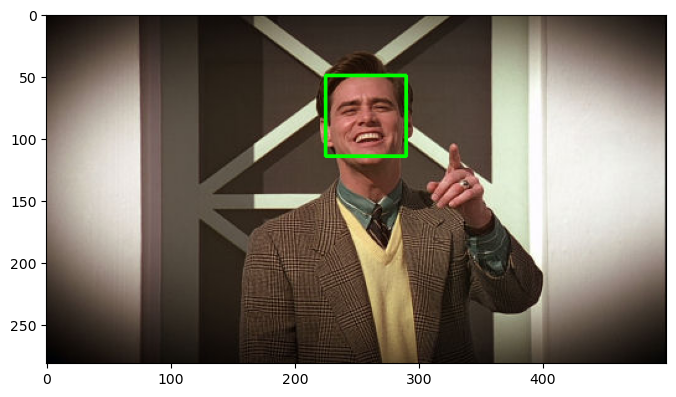

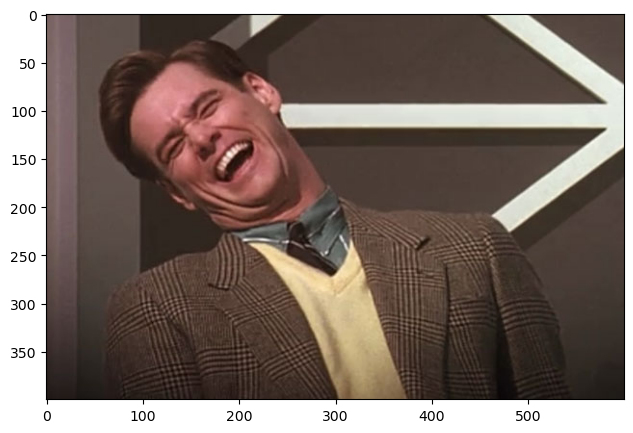

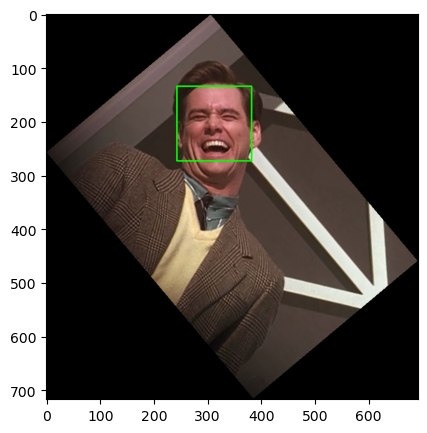

In [105]:
# the model we are using is not robust to inplane rotations, you should check this limitation by comparing 
# the outputs obtained by the following two images 
tr = cv2.imread('truman1.jpg')
rgb = cv2.cvtColor(tr, cv2.COLOR_BGR2RGB)

faces = face_cascade.detectMultiScale(rgb, scaleFactor = 1.1, minNeighbors = 5, flags = 0)
plt.figure(figsize = (8, 5))
draw_rects(rgb, faces, color = (0, 255, 0))
plt.imshow(rgb)
plt.show()

#-----------------------------------------------------------

tr2 = cv2.imread('truman2.jpg')
rgb = cv2.cvtColor(tr2, cv2.COLOR_BGR2RGB)

faces = face_cascade.detectMultiScale(rgb, scaleFactor = 1.1, minNeighbors = 5, flags = 0)
plt.figure(figsize = (8, 5))
draw_rects(rgb, faces, color = (0, 255, 0))
plt.imshow(rgb)
plt.show()

# If you apply an appropriate rotation to the second image, results should improve, why?

# FILL HERE
from scipy import ndimage
tr2_rotated = ndimage.rotate(rgb, -50)
faces = face_cascade.detectMultiScale(tr2_rotated)
plt.figure(figsize = (8, 5))
draw_rects(tr2_rotated, faces, color = (0, 255, 0))
plt.imshow(tr2_rotated)
plt.show()

### Your comments

<div style="background-color: pink; padding: 10px">
The previous tests, involved different types of images and produced different results. Try you reach some conclusion on the limits of the algorithm and, if you want, make an attempt in explaining how they could be mitigated.

It may be interesting to try out other images of your choice (e.g. lateral faces)

**Observations:** 

- In the first test we can notice that almost all the faces are detected correclty the problem occurs with the mask, in fact it is not recognized as a face, probably because it has features little like a real face. 

- In the second test we can notice that all the faces in the foreground that are well lit are detected but in the face of the person in the background is not detected, this is because there is little light to illuminate the face which is also partially occluded by the boy in the foreground. 

- In the third test we can notice that the face is detected only after a rotation of the image. I think that this is because for example if we use a feature with a vertical structure white/black and we use is to detect faces we will be able to detect only those that are positioned in a vertical way. If the face is rotated for example the nose (which generally is a main point, important for the face detection) is rotated too and the feature, sliding onto the image will have more difficulties to detect the intensity transaction of the face in the nose region since it is not vertically positioned. 

### 2.3 (Optional)  Nested classifiers

The same procedure may be used to train other objects / object parts detectors. Here we will consider an <i> eye detector </i> and will call it in a nested modality (that is inside a region where a face was detected)

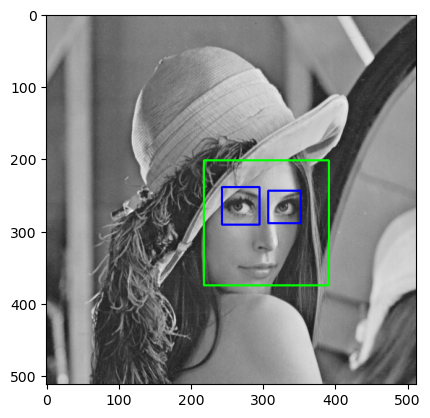

In [118]:
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

img = cv2.imread('Lena.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

faces = face_cascade.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 5, flags = 0)
for (x,y,w,h) in faces:
    draw_rects(img,faces,(0,255,0))
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex +ew,ey+eh),(0,0,255),2) #we are exploiting aliases between matrices...

plt.imshow(img)
plt.show()

### 2.4 (Optional) put a face / eye detector in the webcam loop

The following function may be used to run the face (or face+eye) detector on a live video stream acquired through your cam. Try out different acquisition conditions, try and understand the potential and the limits of this powerfull but simple detector

In [119]:
def show_webcam(width=1000, height=800):
    cam = cv2.VideoCapture(0)
    i=0
    while i<100: # we will acquire 100 frames you may change this if you like
        ret_val, img = cam.read()
             
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # you can first test it like this (to see if your webcam works)
        # then add face detection or face+eye detection and rectangle drawings
        cv2.imshow('my webcam', img)
        cv2.namedWindow('my webcam',cv2.WINDOW_NORMAL)
        cv2.resizeWindow('my webcam', width, height)
        i+=1
    cv2.destroyAllWindows()

In [ ]:
show_webcam()

In [ ]:
# Add some outputs from your camera here if you like (screenshots would do)